# Compare depth-averaged speed from ACCESS-OM2-01 with SOSE and ORAS5.

ACESS-OM2-01 simulations stored on the National Computational Infrastructure (NCI) in Canberra, Australia.  
Access to the 1/12 SOSE simulation was provided by Matthew Mazloff, Scripps Institution of Oceanography, UC San Diego.    
ORAS5 1/4 degree simulation available from:  https://www.cen.uni-hamburg.de/icdc/data/ocean/easy-init-ocean/ecmwf-oras5.htmL.  

In [1]:
import xarray as xr
import numpy as np
from glob import glob
import xmitgcm as xgcm
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean as cmo

import cosima_cookbook as cc

import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [2]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44037,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:38847,Total threads: 3
Dashboard: /proxy/38641/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:36531,


#### Define depth range for averaging

In [9]:
z_range=[0,500]

#### Read in model data

**ACCESS-OM2-01** model **RYF** simulation, 1/10th degree resolution.

In [6]:
%%time
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
start_date = '1950-01-01'
end_date = '1970-12-30'
accessfiles = sorted(glob(data_path+'output19*/ocean/ocean.nc')) +\
            sorted(glob(data_path+'output2*/ocean/ocean.nc'))

def preprocess_u(ds):
    ds = ds.sel(yu_ocean=slice(-80,-60)).sel(st_ocean=slice(z_range[0],z_range[1])).u
    return ds
def preprocess_v(ds):
    ds = ds.sel(yu_ocean=slice(-80,-60)).sel(st_ocean=slice(z_range[0],z_range[1])).v
    return ds
def preprocess_dzt(ds):
    ds = ds.sel(yt_ocean=slice(-80,-60)).sel(st_ocean=slice(z_range[0],z_range[1])).dzt
    return ds

access_u = xr.open_mfdataset(accessfiles, preprocess=preprocess_u).sel(time=slice(start_date, end_date)).u
access_v = xr.open_mfdataset(accessfiles, preprocess=preprocess_v).sel(time=slice(start_date, end_date)).v
access_dzt = xr.open_mfdataset(accessfiles, preprocess=preprocess_dzt).sel(time=slice(start_date, end_date)).dzt
print(access_u.nbytes/1000**3)

65.6667648
CPU times: user 27.6 s, sys: 3.31 s, total: 30.9 s
Wall time: 38.3 s


**ACCESS-OM2-01** model **IAF** simulation, cycle 3, 1/10th deg resolution  
Use only the period for which SOSE data is available (2005 - 2010).

Using cosima cookbook for IAF

In [9]:
session = cc.database.create_session()

In [8]:
expt = '01deg_jra55v140_iaf_cycle3'
start_time = '2005-01-02 00:00:00'
end_time = '2010-12-30 00:00:00'
iaf_access_u = cc.querying.getvar(expt=expt, variable='u', 
                                  session=session, frequency='1 monthly',
                                  #ncfile='ocean-3d-u-1-monthly-mean-ym_*.nc',
                                  attrs={'cell_methods': 'time: mean'},
                                  start_time=start_time, 
                                  end_time=end_time).sel(yu_ocean=slice(-80, -60)).sel(st_ocean=slice(z_range[0],z_range[1]))
iaf_access_v = cc.querying.getvar(expt=expt, variable='v', 
                                  session=session, frequency='1 monthly',
                                  attrs={'cell_methods': 'time: mean'},
                                  #ncfile='ocean_month.nc',
                                  start_time=start_time, 
                                  end_time=end_time).sel(yu_ocean=slice(-80, -60)).sel(st_ocean=slice(z_range[0],z_range[1]))
iaf_access_dzt = cc.querying.getvar(expt=expt, variable='dzt',
                                    session=session, frequency='1 monthly',
                                    #ncfile='ocean_month.nc',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time=start_time, 
                                    end_time=end_time).sel(yt_ocean=slice(-80, -60)).sel(st_ocean=slice(z_range[0],z_range[1]))
print(iaf_access_u.nbytes/1000**3)

18.7619328


**SOSE** 1/12 degree simulation.  
Data is from 2005 to 2010. 

In [10]:
%%time
sose_data_path_U = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Uvel_fixed.nc'
sose_data_path_V = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Vvel_fixed.nc'
sose_U = xr.open_dataset(sose_data_path_U)
# resplace ilon and ilat dimensions with  lat and lon data
sose_U = xr.DataArray(sose_U.uvel_mean.data, coords=[("z", sose_U.depth.data), ("yc", sose_U.lat.data),("xg", sose_U.lon.data), ])
sose_U = sose_U.sel(yc=slice(-82,-59)).sel(z=slice(z_range[0],z_range[1]+100)).load()
sose_V = xr.open_dataset(sose_data_path_V)
sose_V = xr.DataArray(sose_V.vvel_mean.data, coords=[("z", sose_V.depth.data), ("yg", sose_V.lat.data),("xc", sose_V.lon.data), ])
sose_V = sose_V.sel(yg=slice(-82,-59)).sel(z=slice(z_range[0],z_range[1]+100)).load()

CPU times: user 815 ms, sys: 3.59 s, total: 4.4 s
Wall time: 4.91 s


**ORAS025** model, 1/4 deg resolution.  
Read this in as a loop below (when speed is calculated) since there are 5 ensemble members.  

#### Calculate speed. 

In [11]:
%%time
# ACCESS RYF
# Model uses an Arakawa-B grid with both U and V located on the same horizontal and vertical points. 
# As such, no interpolation is required between U and V to calculate speed.
u2 = xr.ufuncs.square(access_u)
v2 = xr.ufuncs.square(access_v)
access_spd = xr.ufuncs.sqrt(u2 + v2).mean(dim='time').compute()
cell_dzt = access_dzt.mean(dim='time').compute()
# calculate depth-weighted mean to account for differing vertical size of grid cells
access_spd = (access_spd.isel(yu_ocean=slice(0,-1)) * (cell_dzt/cell_dzt.sum(dim='st_ocean').values).values).sum(dim='st_ocean')
access_spd = access_spd.where(access_spd>0., np.nan)
access_spd = access_spd.rename('spd')

# save to file
access_spd.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/ryf_access_spd_{z_range[0]}-{z_range[1]}.nc')

CPU times: user 31.8 s, sys: 9.47 s, total: 41.3 s
Wall time: 5min 41s


In [12]:
%%time
# ACCESS IAF
# Model uses an Arakawa-B grid with both U and V located on the same horizontal and vertical points. 
# As such, no interpolation is required between U and V to calculate speed.
u2 = xr.ufuncs.square(iaf_access_u)
v2 = xr.ufuncs.square(iaf_access_v)
iaf_access_spd = xr.ufuncs.sqrt(u2 + v2).mean(dim='time').compute()
cell_dzt = iaf_access_dzt.mean(dim='time').compute()
iaf_access_spd = (iaf_access_spd.isel(yu_ocean=slice(0,-1)) * (cell_dzt/cell_dzt.sum(dim='st_ocean').values).values).sum(dim='st_ocean')
iaf_access_spd = iaf_access_spd.where(iaf_access_spd>0., np.nan)
iaf_access_spd = iaf_access_spd.rename('spd')

# save to file
iaf_access_spd.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/iaf_access_spd_{z_range[0]}-{z_range[1]}.nc')

CPU times: user 3min 9s, sys: 10.8 s, total: 3min 20s
Wall time: 4min 3s


In [13]:
%%time
# SOSE
# Model is an Arakawa-C grid. U is located in the center on the left tracer cell face, while
# V is located in the center of the front ('north') tracer cell face. 
# As such, we need to inerpolate one onto the other to calculate speed. 
# We will interpolate V onto U using xgcm. 

# combine U and V into one dataset
sose_velocity = xr.Dataset({'sose_u':sose_U,
                            'sose_v':sose_V.isel(yg = slice(None,-1)),})

# create xgcm grid object
sose_grid = Grid(sose_velocity,
                 coords = {'X':{'center':'xc','left':'xg'},
                           'Y':{'center':'yc','left':'yg'},
                           'Z':{'center':'z'}}, periodic=['X','Y'])

# Interpolate V (xc, yg) in the Y direction so new dims are (xc,yc).
# Then interpolate in X to get dimensions to (yc, xg), the same as the u points.
print("Interpolating V-vel onto U-vel grid points...")
sose_v = sose_grid.interp(sose_velocity.sose_v, 'Y', boundary='fill') 
sose_v = sose_grid.interp(sose_v,'X',boundary='fill') 

# now calculate speed
print("Calculating speed...")
sose_v_sqr = xr.ufuncs.square(sose_v)
sose_u_sqr = xr.ufuncs.square(sose_velocity.sose_u)
sose_spd = xr.ufuncs.sqrt(sose_u_sqr + sose_v_sqr)

# I do not have vertical grid cell thickness for this simulation.
# Generate this missing vertical grid thickness information using xgcm. 
sose_velocity_full = generate_grid_ds(sose_velocity, {'Z':'z'})
grid = Grid(sose_velocity_full, periodic=['X','Y'])
# Calculate vertical distances located on the cell-boundary
sose_velocity_full.coords['dzc'] = grid.diff(sose_velocity_full.z, 'Z',)
# Calculate vertical distances located on the cell-center
sose_velocity_full.coords['dzt'] = grid.diff(sose_velocity_full.z_left, 'Z', )

# Now calculate depth-weighted average. 
# The first value of dzc is incorrect using this grid.diff method
# so use dzt instead which differs from dzc by <= 1m over this depth range. 
sose_spd = sose_spd.sel(z=slice(z_range[0], z_range[1])).weighted(sose_velocity_full.dzt.sel(z=slice(z_range[0], z_range[1])))
sose_spd = sose_spd.mean(dim='z')
sose_spd = sose_spd.rename('spd')

# save to file
sose_spd.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/sose_spd_{z_range[0]}-{z_range[1]}.nc')

Interpolating V-vel onto U-vel grid points...
Calculating speed...
CPU times: user 4.86 s, sys: 4.19 s, total: 9.05 s
Wall time: 8.39 s


In [21]:
%%time
# ORAS5 (1/4 degree resolution) comprises an ensemble of 5 runs with different perturbations to the initial conditions, 
# forcings, and observations (https://os.copernicus.org/articles/15/779/2019/). 
# We will calculate the depth-averaged speed for each ensemble and then take the average of these at the end.

# define path
sim = np.arange(0,5,1)
sim_name = ['opa0','opa1','opa2','opa3','opa4']
oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'

# use same period as SOSE simulation
start_time = '2005-01-01'
end_time = '2010-12-30'

# define preprocess functions to limit model domain when reading in
def preprocess_U(ds):
    ds = ds.sel(y=slice(0,200)).sel(depthu=slice(z_range[0],z_range[1]+100)).vozocrtx
    return ds
def preprocess_V(ds):
    ds = ds.sel(y=slice(0,200)).sel(depthv=slice(z_range[0],z_range[1]+100)).vomecrty
    return ds

# loop through enemble members
for i, s in enumerate(sim):
    print(i,s)
    # read in model data ----------------------------------------
    oras5_Ufiles = sorted(glob(oras5_data_path+f'vozocrtx/{sim_name[i]}/vozocrtx_*.nc')) 
    oras5_Vfiles = sorted(glob(oras5_data_path+f'vomecrty/{sim_name[i]}/vomecrty_*.nc')) 
    # read in U and V data
    oras5_U = xr.open_mfdataset(oras5_Ufiles, preprocess=preprocess_U).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time, end_time)).chunk({'time_counter':3,'depthu':40,})
    #oras5_Uref = xr.open_mfdataset(oras5_Ufiles[0:1], preprocess=preprocess_U)
    oras5_Uref = xr.open_mfdataset(oras5_Ufiles[0:1]).sel(y=slice(0,200)).vozocrtx
    oras5_V = xr.open_mfdataset(oras5_Vfiles, preprocess=preprocess_V).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time, end_time)).chunk({'time_counter':3,'depthv':40,})
    oras5_Vref = xr.open_mfdataset(oras5_Vfiles[0:1], preprocess=preprocess_V)
    oras5_U = oras5_U['vozocrtx']
    oras5_V = oras5_V['vomecrty']
    # replace x and y indices with lat and lon data
    latu, lonu = oras5_Uref.nav_lat[:,0].values, oras5_Uref.nav_lon[0,:].values
    latv, lonv = oras5_Vref.nav_lat[:,0].values, oras5_Vref.nav_lon[0,:].values
    oras5_U['x'] = lonu
    oras5_U['y'] = latu
    oras5_V['x'] = lonv
    oras5_V['y'] = latv
    print(oras5_U.nbytes/1000**3, oras5_V.nbytes/1000**3)

    # Now calculate speed ----------------------------------------
    # As for SOSE, ORAS5 uses an Arakawa-C grid. U is located in the center on the right tracer cell face, 
    # while V is located in the center of the front ('north') tracer cell face. 
    # As such, we need to interpolate one onto the other to calculate speed. 
    # We will interpolate V onto U using xgcm. 

    # combine U and V into one dataset
    # first rename, x and y dimensions
    oras5_U = oras5_U.rename({'y':'yc', 'x':'xf','depthu':'zc'}) 
    oras5_V = oras5_V.rename({'y':'yf', 'x':'xc','depthv':'zc'}) 
    oras5_velocity = xr.Dataset({'oras5_u':oras5_U,
                                'oras5_v':oras5_V,})

    # create xgcm grid object
    oras5_grid = Grid(oras5_velocity,
                     coords = {'X':{'center':'xc','right':'xf'},
                               'Y':{'center':'yc','right':'yf'},
                               'Z':{'center':'zc'}}, periodic=['X','Y'])

    # Interpolate V in the y direction so new dims are (xc,yc).
    # Then interpolate in x to get dimensions to (xf,yc), the same as the U points.
    print("Interpolating V-vel onto U-vel grid points...")
    oras5_v = oras5_grid.interp(oras5_velocity.oras5_v, 'Y', boundary='fill') 
    oras5_v = oras5_grid.interp(oras5_v,'X',boundary='fill')  

    # calculate speed
    print("Calculating speed...")
    oras5_v_sqr = xr.ufuncs.square(oras5_v)
    oras5_u_sqr = xr.ufuncs.square(oras5_velocity.oras5_u)
    oras5_spd = xr.ufuncs.sqrt(oras5_u_sqr + oras5_v_sqr)

    # I do not have cell thickness/grid information for this simulation.
    # Generate this missing vertical grid thickness information using xgcm. 
    oras5_velocity_full = generate_grid_ds(oras5_velocity, {'Z':'zc'})
    grid = Grid(oras5_velocity_full, periodic=['X','Y'])
    # Calculate vertical distances located on the cellboundary
    oras5_velocity_full.coords['dzc'] = grid.diff(oras5_velocity_full.zc, 'Z',)
    # Calculate vertical distances located on the cellcenter
    oras5_velocity_full.coords['dzt'] = grid.diff(oras5_velocity_full.zc_left, 'Z', )

    # caculate depth-averaged speed with dzc 
    oras5_cell_dz = (oras5_Uref.depthu[1:].values - oras5_Uref.depthu[0:-1]).sel(depthu=slice(z_range[0], z_range[1]))
    dzt_arr = np.tile(oras5_cell_dz.values[:, np.newaxis, np.newaxis], (1, 200, 1442))
    oras5_spd_dzc = (oras5_spd.sel(zc=slice(z_range[0], z_range[1]))*dzt_arr/(oras5_cell_dz.sum().values)).sum(dim='zc').mean(dim='time_counter').compute()
    oras5_spd_dzc = oras5_spd_dzc.where(oras5_spd_dzc > 0., np.nan)
    oras5_spd_dzc = oras5_spd_dzc.rename('spd')
    # save to file
    oras5_spd_dzc.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_{sim_name[i]}_spd_{z_range[0]}-{z_range[1]}_dzc_2005-2010.nc')

    # caculate depth-averaged speed with dzt
    dzt_sum = oras5_velocity_full.dzt.sel(zc=slice(z_range[0], z_range[1])).sum()
    oras5_spd_dzt = ((oras5_spd.sel(zc=slice(z_range[0], z_range[1]))*oras5_velocity_full.dzt.sel(zc=slice(z_range[0], z_range[1])))/dzt_sum).sum(dim='zc').mean(dim='time_counter')
    oras5_spd_dzt = oras5_spd_dzt.where(oras5_spd_dzt > 0., np.nan)
    oras5_spd_dzt = oras5_spd_dzt.rename('spd')
    # save to file
    oras5_spd_dzt.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_{sim_name[i]}_spd_{z_range[0]}-{z_range[1]}_dzt_2005-2010.nc')

0 0
3.4054272 3.4054272
Interpolating V-vel onto U-vel grid points...
Calculating speed...
1 1
3.4054272 3.4054272
Interpolating V-vel onto U-vel grid points...
Calculating speed...
2 2
3.4054272 3.4054272
Interpolating V-vel onto U-vel grid points...
Calculating speed...
3 3
3.4054272 3.4054272
Interpolating V-vel onto U-vel grid points...
Calculating speed...
4 4
3.4054272 3.4054272
Interpolating V-vel onto U-vel grid points...
Calculating speed...
CPU times: user 3min 47s, sys: 34.5 s, total: 4min 21s
Wall time: 11min 36s


Now average the individual depth-weighted, upper ocean enemble speeds in one file. 

In [23]:
ora_spd_files = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_*_spd_0-500_dzc_2005-2010.nc'))
ds0 = xr.open_dataset(ora_spd_files[0])
ds1 = xr.open_dataset(ora_spd_files[1])
ds2 = xr.open_dataset(ora_spd_files[2])
ds3 = xr.open_dataset(ora_spd_files[3])
ds4 = xr.open_dataset(ora_spd_files[4])
ds = ds0.copy(deep=True)
ds['spd'] = (ds0.spd+ds1.spd+ds2.spd+ds3.spd+ds4.spd)/5.
ds.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_ensemble_mean_spd_{z_range[0]}-{z_range[1]}_dzc.nc')

ora_spd_files = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_*_spd_0-500_dzt_2005-2010.nc'))
ds0 = xr.open_dataset(ora_spd_files[0])
ds1 = xr.open_dataset(ora_spd_files[1])
ds2 = xr.open_dataset(ora_spd_files[2])
ds3 = xr.open_dataset(ora_spd_files[3])
ds4 = xr.open_dataset(ora_spd_files[4])
ds = ds0.copy(deep=True)
ds['spd'] = (ds0.spd+ds1.spd+ds2.spd+ds3.spd+ds4.spd)/5.
ds.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/oras5_ensemble_mean_spd_{z_range[0]}-{z_range[1]}_dzt.nc')

#### Define figure functions

In [7]:
fontsize = 16
subplot_titles = ['ACCESS-OM2-01 \nRYF years 50-70',
                  'ACCESS-OM2-01 \nIAF 2005-2010',
                  'SOSE-1/12 \n2005-2010',
                  'ORAS5 \n2005-2010']
subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)']

## access data required for lat/lon mapping and bathymetry contours
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = (ht*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yt_ocean =ht.yt_ocean.values
yt_ocean[0]=-90
xt_ocean =ht.xt_ocean.values

## sose land mask
sose_land_mask = sose_U[0,:,:].copy()
sose_land_mask = (sose_land_mask*0+1).fillna(0)

## oras5 land mask
oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'
oras5_Ufiles = sorted(glob(oras5_data_path+'vozocrtx/opa0/vozocrtx_*.nc')) 
oras5_Uref = xr.open_mfdataset(oras5_Ufiles[0:1]).sel(y=slice(0,200)).vozocrtx
latu, lonu = oras5_Uref.nav_lat[:,0].values, oras5_Uref.nav_lon[0,:].values
oras5_land_mask = oras5_Uref[0,0,:,:].copy()*0
oras5_land_mask = oras5_land_mask.fillna(1)
oras5_land_mask['y'] = latu
oras5_land_mask['x'] = lonu
x =  oras5_land_mask.x.values
x[1149] = 0
new_x = np.sort(np.concatenate((oras5_land_mask.x[430:],oras5_land_mask.x[:430]))) 
oras5_land_mask = xr.concat((oras5_land_mask[:,430:], oras5_land_mask[:,0:430]), dim='x')#.drop_vars(['nav_lat', 'nav_lon'])
oras5_land_mask['x'] = new_x

## define circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def map_elements(axes):
    for i, ax in enumerate(axes.flatten()):
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='w',linewidths=1,transform = ccrs.PlateCarree())
        ax.set_extent([-280, 80, -90, -61], ccrs.PlateCarree())
        ax.text(0.09, 0.93, subplot_labels[i],fontsize=23, fontweight='bold',transform = ax.transAxes)
        ax.text(0.55, 0.5, subplot_titles[i],fontsize=15, ha='center',va='center',transform = ax.transAxes)
        
def plot_colorbar_horz(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'horizontal',extend = 'max', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def plot_colorbar_vert(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = 'max', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar

## 2 x 2 figure
def figure_spd_zrange_2by2(z_range):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,2,figsize=(15,15),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.0, hspace=0.01)
    map_elements(axes)
    return fig, axes

#### Read in speed data.

In [8]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/model_comparison/'
ryf_access_spd = xr.open_dataset(datadir + 'ryf_access_spd_0-500.nc')
iaf_access_spd = xr.open_dataset(datadir + 'iaf_access_spd_0-500.nc')
sose_spd = xr.open_dataset(datadir + 'sose_spd_0-500.nc')
oras5_spd = xr.open_dataset(datadir + 'oras5_ensemble_mean_spd_0-500_dzc.nc')

#### **Figure 1:** Depth averaged speed without transects

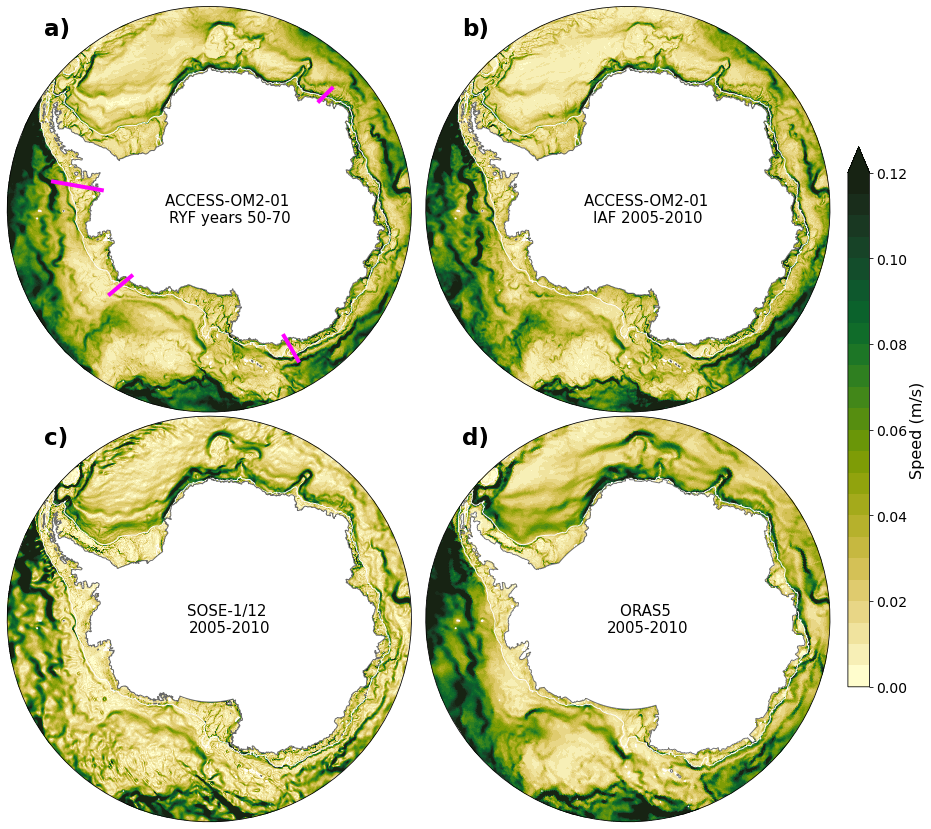

In [9]:
fig, axes = figure_spd_zrange_2by2(z_range)
vmin, vmax = 0, 0.12
cmap = cmo.cm.speed._resample(24)
trnsct_lon = [45,150,-130,-80]
trnsct_lats = [-68,-69,-75,-74]
trnsct_latn = [-65.5,-65,-71,-67]

# plot access RYF
cb_var = axes[0][0].pcolormesh(ryf_access_spd.xu_ocean, ryf_access_spd.yu_ocean, ryf_access_spd.spd,
               cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
axes[0][0].contour(xt_ocean, yt_ocean, land_mask.values, [0,1], zorder=3,
                 colors='dimgrey', alpha=1, linewidths=0.9, transform = ccrs.PlateCarree())

# plot access IAF
cb_var = axes[0][1].pcolormesh(iaf_access_spd.xu_ocean, iaf_access_spd.yu_ocean, iaf_access_spd.spd,
               cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
axes[0][1].contour(xt_ocean, yt_ocean, land_mask.values, [0,1], zorder=3,
                 colors='dimgrey', alpha=1, linewidths=0.9, transform = ccrs.PlateCarree())

# plot sose 
axes[1][0].pcolormesh(sose_spd.xg, sose_spd.yc, sose_spd.spd,
               cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
axes[1][0].contour(sose_land_mask.xg, sose_land_mask.yc, sose_land_mask, [0,1], 
                colors='dimgrey',linewidths=0.9,transform = ccrs.PlateCarree())

# plot oras5 speed
ora_lon = oras5_Uref.nav_lon[0,:].values
ora_lat = oras5_Uref.nav_lat[:,0].values
axes[1][1].pcolormesh(ora_lon, ora_lat, oras5_spd.spd,
               cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
axes[1][1].contour(oras5_land_mask.x, oras5_land_mask.y, oras5_land_mask, [0,1], 
                colors='dimgrey',linewidths=0.9,transform = ccrs.PlateCarree())

# plot transects for Fig 2 on panel a)
for j in range(4):
    axes[0][0].plot([trnsct_lon[j], trnsct_lon[j]],[trnsct_lats[j], trnsct_latn[j]],
            c='magenta', lw=4,zorder=4,transform=ccrs.PlateCarree())

# add colorbar
plot_colorbar_vert(fig,[0.91,0.25,0.02,0.5],cb_var,'Speed (m/s)')
plt.show()

# save to file
figdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
figfilename = figdir+f'Fig01_model_spd_comparison_{z_range[0]}-{z_range[1]}m.jpg'
fig.savefig(figfilename, bbox_inches='tight', dpi=300)

In [44]:
def map_elements(ax):
    ax.set_boundary(circle, transform=ax.transAxes)
    #ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='w',linewidths=1,transform = ccrs.PlateCarree())
    ax.set_extent([-280, 80, -90, -61], ccrs.PlateCarree())
    #ax.text(0.09, 0.93, subplot_labels[0],fontsize=23, fontweight='bold',transform = ax.transAxes)
    ax.text(0.55, 0.5, subplot_titles[0],fontsize=15, ha='center',va='center',transform = ax.transAxes)

def figure_spd_comparison():
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(1,1,figsize=(12,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.0, hspace=0.01)
    map_elements(axes)
    return fig, axes

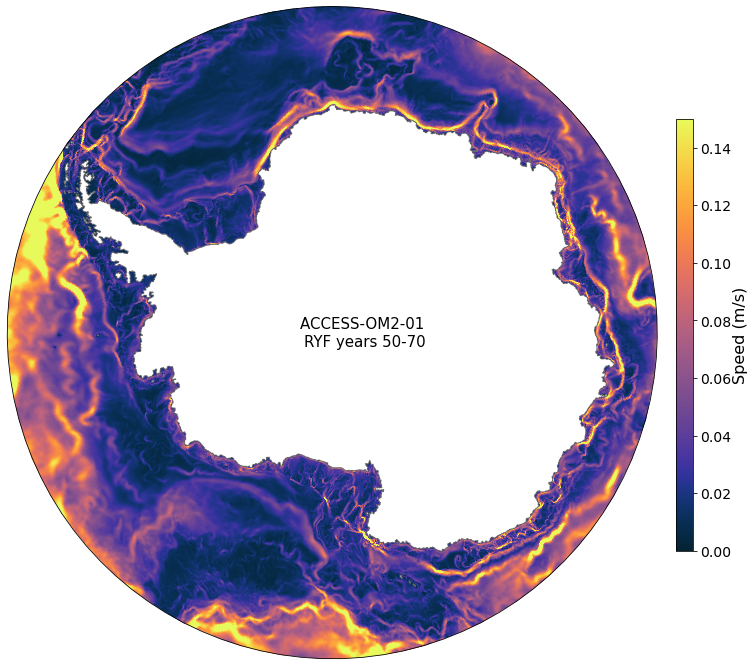

In [45]:
fig, axes = figure_spd_comparison()
cmap = cmo.cm.thermal
vmin, vmax = 0, 0.15

cb_var = axes.pcolormesh(ryf_access_spd.xu_ocean, ryf_access_spd.yu_ocean, ryf_access_spd.spd,
               cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
axes.contour(xt_ocean, yt_ocean, land_mask.values, [0,1], zorder=3,
                 colors='dimgrey', alpha=1, linewidths=0.9, transform = ccrs.PlateCarree())

cbaxes = fig.add_axes([0.91,0.25,0.02,0.5])
cbar = plt.colorbar(cb_var, cax = cbaxes, orientation = 'vertical',extend = None, shrink=0.5)
cbar.set_label('Speed (m/s)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=14)

# save to file
figdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
figfilename = figdir+'for_reviewer_response_model_spd_comparison.jpg'
fig.savefig(figfilename, dpi=300)

plt.show()